This is a script for building models for post-processing NWP visibility forecasts to produce calibrated deterministic forecasts using random forest regression applying the lead-time-continuous approach.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pickle
import time

/Users/clifflau/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Change paths for own use
data_path = "ROOT/preprocessed_data/"
model_export_path = "ROOT/trained_models/lead_time_continuous/"
result_export_path = "ROOT/test_results_df/lead_time_continuous/"

In [3]:
df_train = pd.read_csv(data_path + "df_training.csv", dtype={'time_in_day':'category'})
df_valid = pd.read_csv(data_path + "df_valid.csv", dtype={'time_in_day':'category'})
df_test = pd.read_csv(data_path + "df_test.csv", dtype={'time_in_day':'category'})
df_baseline = pd.read_csv(data_path + "df_training_baseline.csv", dtype={'time_in_day':'category'})

In [6]:
len(df_train)

6150768

In [4]:
# Sample 10% of training records for faster training (comment out if necessary)
df_train = df_train.sample(frac=0.1, random_state=1)

In [10]:
# List of input features (using ensemble means and std for visibility foreasts)
features = ['lead_hr', 'station_alt', 'dis_from_coast', 'time_in_day', 'day_in_year_sin', 'day_in_year_cos',
                    't_ensemble_mean', 't_ensemble_std',
                    'q_ensemble_mean', 'q_ensemble_std',
                    'tp6_ensemble_mean', 'tp6_ensemble_std',
                    'tcc_ensemble_mean', 'tcc_ensemble_std',
                    'wind_ensemble_mean', 'wind_ensemble_std',
                    'vis_ensemble_mean', 'vis_ensemble_std']

# List of input features (using proportions of members forecasting each visibility index for visibility forecasts)
# Uncomment if necessary
'''
features_prop = ['lead_hr', 'station_alt', 'dis_from_coast', 'time_in_day', 'day_in_year_sin', 'day_in_year_cos',
                    't_ensemble_mean', 't_ensemble_std',
                    'q_ensemble_mean', 'q_ensemble_std',
                    'tp6_ensemble_mean', 'tp6_ensemble_std',
                    'tcc_ensemble_mean', 'tcc_ensemble_std',
                    'wind_ensemble_mean', 'wind_ensemble_std',
                'member_prop_VP','member_prop_P','member_prop_M','member_prop_G','member_prop_VG', 'member_prop_E']
'''

x_train = df_train[features]
y_train = df_train['vis_obs']
#y_train = np.log(df_train['vis_obs']+0.00001) # Log transformation (uncomment for transformation of output)

x_valid = df_valid[features]
y_valid = df_valid['vis_obs']
#y_valid = df_valid['vis_obs']+0.00001 # Log transformation (uncomment for transformation of output)

x_test = df_test[features]
y_test = df_test['vis_obs']
#y_test = df_test['vis_obs']+0.00001 # Log transformation (uncomment for transformation of output)

# One-hot encode categorical 'time_in_day'
x_train = x_train.join(pd.get_dummies(x_train['time_in_day']))
x_train = x_train.drop('time_in_day',axis=1)
x_valid = x_valid.join(pd.get_dummies(x_valid['time_in_day']))
x_valid = x_valid.drop('time_in_day',axis=1)
x_test = x_test.join(pd.get_dummies(x_test['time_in_day']))
x_test = x_test.drop('time_in_day',axis=1)

In [11]:
x_train.shape, x_valid.shape, x_test.shape

((6150768, 21), (650999, 21), (647208, 21))

In [12]:
x_train.columns

Index(['lead_hr', 'station_alt', 'dis_from_coast', 'day_in_year_sin',
       'day_in_year_cos', 't_ensemble_mean', 't_ensemble_std',
       'q_ensemble_mean', 'q_ensemble_std', 'tp6_ensemble_mean',
       'tp6_ensemble_std', 'tcc_ensemble_mean', 'tcc_ensemble_std',
       'wind_ensemble_mean', 'wind_ensemble_std', 'vis_ensemble_mean',
       'vis_ensemble_std', '06', '12', '18', '00'],
      dtype='object')

In [13]:
st = time.time()

rf = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=18)
rf.fit(x_train, y_train)

# Save the model
with open(model_export_path + 'giant_100_5_all_records.pkl.pkl','wb') as f:
    pickle.dump(rf,f)

y_pred_valid_rf = rf.predict(x_valid)
#y_pred_valid_rf = np.exp(rf.predict(x_valid)) # Log transformation (uncomment for transformation of output)
valid_error_rf = np.array(y_valid) - y_pred_valid_rf

valid_rmse_rf = np.sqrt(np.mean(valid_error_rf**2))
        
et = time.time()
elapsed_time = et - st

print("Validation RMSE: %s (execution time: %s s)"%(valid_rmse_rf, elapsed_time))

Validation RMSE: 16711.517062070983 (execution time: 3928.592406988144 s)


In [2]:
# Run time record:
# (n_estimators, max_depth, training size): validation RMSE, run time
# (30,20,6M): 15226 m, 4001 s
# (30,20,600k): 15435 m, 292 s
# (60,20,600k): 15378 m, 618 s
# (100,20,600k): 15358 m, 1747 s
# (300,20,600k): 15333 m, 2884 s
# (100,20,1.8M): 15274 m, 3572 s
# (400,5,600K): 16754 m, 1493 s
# (100,10,600K): 15726 m, 572 s
# (200,10,600K): 15730 m, 1163 s
# (300,10,600K): 15729 m, 2053 s
# (100,15,600K): 15447 m, 1272 s
# (200,15,600K): 15440 m, 4541 s
# (200,20,600K): 15340 m, 3741 s

In [15]:
# Open previously trained model (uncomment if necessary)
#with open(model_export_path + 'giant_300_20.pkl', 'rb') as f:
    #rf = pickle.load(f)

Text(0.5, 1.0, 'Features Importances from RF')

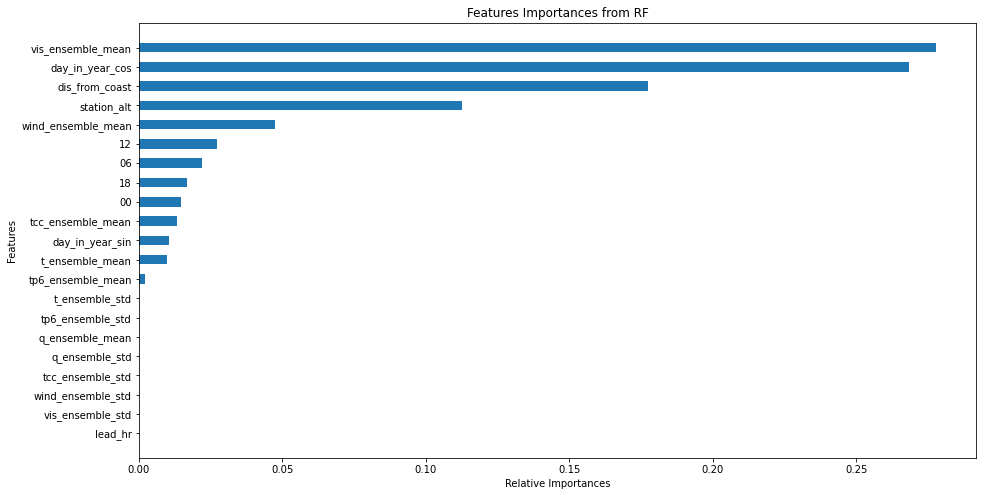

In [14]:
# Feature importance
plt.figure(figsize=(15,8))
importances = rf.feature_importances_
features = x_train.columns
indices = np.argsort(importances)
plt.barh(np.arange(len(features)), importances[indices], height=0.5)
plt.yticks(np.arange(len(features)), features[indices])
plt.ylabel("Features")
plt.xlabel("Relative Importances")
plt.title("Features Importances from RF")

In [15]:
# Test errors of NWP forecasts (before post-processing)
test_error_forecast = np.array(y_test)-np.array(df_test['vis_ensemble_mean'])

In [16]:
# Test error of post-processed forecasts
y_pred_test_rf = rf.predict(x_test)
#y_pred_test_rf = np.exp(rf.predict(x_test)) # Log transformation (uncomment for transformation of output)
test_error_rf = np.array(y_test)-y_pred_test_rf

In [17]:
# Baseline forecasts modelling raw visibility observations
baseline_by_forecast_time = []
for i in ['00','06','12','18']:
    baseline_by_forecast_time.append(np.mean(df_baseline[df_baseline['time_in_day']==i]['vis_obs']))

y_pred_test_baseline = np.array([0]*len(y_test))
for i in range(len(y_test)):
    if df_test['time_in_day'][i]=='00':
        y_pred_test_baseline[i] = baseline_by_forecast_time[0]
    elif df_test['time_in_day'][i]=='06':
        y_pred_test_baseline[i] = baseline_by_forecast_time[1]
    elif df_test['time_in_day'][i]=='12':
        y_pred_test_baseline[i] = baseline_by_forecast_time[2]
    elif df_test['time_in_day'][i]=='18':
        y_pred_test_baseline[i] = baseline_by_forecast_time[3]

test_error_baseline = np.array(y_test)-y_pred_test_baseline

# Baseline model modelling transformed visibility observations (uncomment if necessary)
'''baseline_by_forecast_time = []
for i in ['00','06','12','18']:
    baseline_by_forecast_time.append(np.exp(np.mean(np.log(df_baseline[df_baseline['time_in_day']==i]['vis_obs']+0.00001))))

y_pred_test_baseline = np.array([0]*len(y_test))
for i in range(len(y_test)):
    if df_test['time_in_day'][i]=='00':
        y_pred_test_baseline[i] = baseline_by_forecast_time[0]
    elif df_test['time_in_day'][i]=='06':
        y_pred_test_baseline[i] = baseline_by_forecast_time[1]
    elif df_test['time_in_day'][i]=='12':
        y_pred_test_baseline[i] = baseline_by_forecast_time[2]
    elif df_test['time_in_day'][i]=='18':
        y_pred_test_baseline[i] = baseline_by_forecast_time[3]
        
test_error_baseline = np.array(y_test)-y_pred_test_baseline'''

"baseline_by_forecast_time = []\nfor i in ['00','06','12','18']:\n    baseline_by_forecast_time.append(np.exp(np.mean(np.log(df_baseline[df_baseline['time_in_day']==i]['vis_obs']+0.00001))))\n\ny_pred_test_baseline = np.array([0]*len(y_test))\nfor i in range(len(y_test)):\n    if df_test['time_in_day'][i]=='00':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[0]\n    elif df_test['time_in_day'][i]=='06':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[1]\n    elif df_test['time_in_day'][i]=='12':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[2]\n    elif df_test['time_in_day'][i]=='18':\n        y_pred_test_baseline[i] = baseline_by_forecast_time[3]\n        \ntest_error_baseline = np.array(y_test)-y_pred_test_baseline"

In [18]:
# Create a dataframe for storing test results
df_result_test = df_test[['base', 'lead_hr', 'forecast_time', 'time_in_day', 'vis_obs', 'vis_ensemble_mean']]
df_result_test['vis_rf'] = y_pred_test_rf
df_result_test['vis_baseline'] = y_pred_test_baseline
df_result_test['error_baseline'] = test_error_baseline
df_result_test['error_nwp'] = test_error_forecast
df_result_test['error_rf'] = test_error_rf
df_result_test.to_csv(result_export_path + "results_5_100_all_records.csv", index=False)
# File format: results_[max_depth]_[n_estimators]_[model variations: optional].csv

<ipython-input-18-ed4539532d01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_test['vis_rf'] = y_pred_test_rf
<ipython-input-18-ed4539532d01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_test['vis_baseline'] = y_pred_test_baseline
<ipython-input-18-ed4539532d01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas